## Image Classification and CIFAR-10

---

### **1. Getting Started with Image Classification and CIFAR-10**

Welcome to **Project 04**! In this project, we move beyond tabular datasets and enter the rich world of **image data**.

Our task is to build a neural network that can classify small color images from the **CIFAR-10** dataset. This is a classic problem in deep learning and computer vision.

> **🧠 What Is Image Classification?**

**Image classification** is the process of assigning a **label** to an image based on its content. For example:

- An image of a 🐸 → class: `"frog"`
- An image of a 🚗 → class: `"automobile"`

Unlike previous datasets where each row represented structured features (e.g., age, income), images are **grids of pixel values**. That makes things both interesting and challenging.

> **🗂️ The CIFAR-10 Dataset** : Source: https://www.cs.toronto.edu/~kriz/cifar.html

We’ll use the popular **CIFAR-10** dataset:
- 📦 60,000 color images of shape **32×32 pixels**
- 🎯 10 classes — each image belongs to one of these: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

- 🔀 Split into 50,000 training images and 10,000 test images
- 🎨 Each image has 3 color channels: Red, Green, Blue (RGB)

The small size (32×32) makes CIFAR-10 ideal for quick experiments — but it’s still visually rich and challenging.

> First Look: Sample Images from CIFAR-10

Let’s now preview a few images from the dataset to get a feel for what the model will be working with.

In [4]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Load CIFAR-10 training set (we’ll reuse this later too)
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# get class names
class_names = train_dataset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


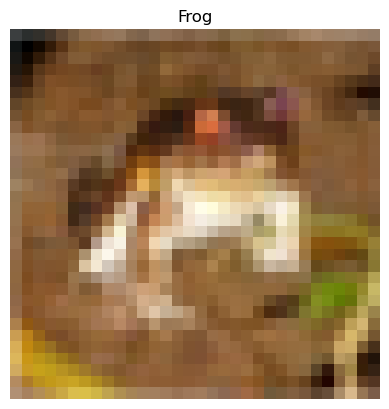

In [6]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title('Frog')
plt.axis('off')
plt.show();

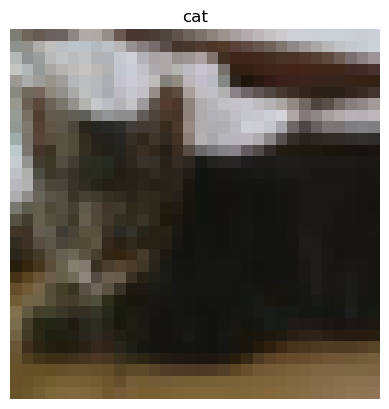

In [7]:
plt.imshow(train_dataset[9][0].permute(1,2,0))
plt.title(class_names[train_dataset[9][1]])
plt.axis('off');

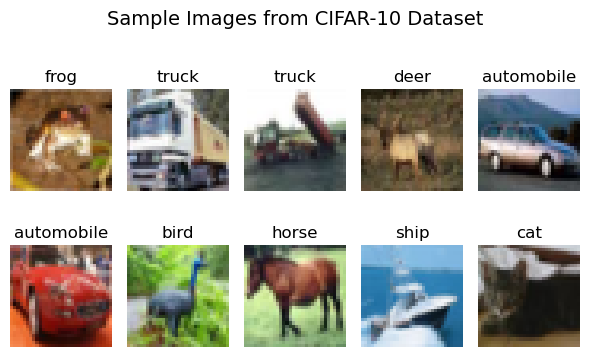

In [8]:
# plot some random images
fig, axes = plt.subplots(2, 5, figsize=(6, 4))

for i in range(10):
    image, label = train_dataset[i]
    ax = axes[i//5, i%5]
    ax.imshow(image.permute(1,2,0)) # reorienting CHW to HWC
    ax.set_title(class_names[label])
    ax.axis('off')
plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=14)
plt.tight_layout()
plt.show();

**Check Class Distribution**

Before training any model, it’s important to check if the dataset is **balanced** — i.e., roughly an equal number of  samples per class.

Unbalanced datasets can bias the model toward frequent classes and lead to poor performance on rare classes.

Let’s count how many images exist per class in the training set.

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


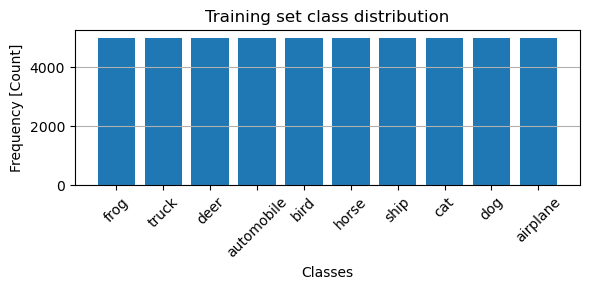

In [9]:
from collections import Counter

labels = [label for _, label in train_dataset]
class_count = Counter(labels)
print(class_count)
# Convert to class name keys
class_count_name = {class_names[k] : v for k, v in class_count.items()}

plt.figure(figsize=(6, 3))
plt.bar(class_count_name.keys(), class_count_name.values())
plt.xlabel('Classes')
plt.ylabel('Frequency [Count]')
plt.title('Training set class distribution')
plt.xticks(rotation = 45)
plt.grid(axis='y')
plt.tight_layout()
plt.show();

>**Now, why Neural Networks?**

Image classification is **not trivial** — even small 32×32 images contain thousands of pixel values.

Some challenges:
- Each image has **3 color channels** (RGB)
- Each class varies in **shape, color, orientation**
- There's **no fixed feature set** like age or income

We need models that can learn directly from raw pixel inputs, discover **patterns**, **textures**, **shapes** and handle **high-dimensional inputs**.

➡️ That’s why we turn to **Neural Networks** — especially **Convolutional Neural Networks (CNNs)** in future projects.


>🧭 Where Are We Headed?

In this notebook, we’ll:
1. Build a **simple MLP** to classify CIFAR-10 images
2. Learn how to **flatten images** for MLP input
3. Observe **performance limitations** of MLPs on image data
4. Reflect on **why we need CNNs** going forward


Let’s now dive into how these images are represented as tensors, and how pixel values are prepared for neural network input.

---

**✅ Code Task 4.1.1.1 – Count Training Samples per Class**

📘 Goal: 
Count the number of samples for each class in the CIFAR-10 training dataset and print them with class names. This will help confirm class balance in the dataset.

(Reminder: All variables for tasks use CT_ prefix to avoid conflicts.)

In [10]:
from collections import Counter

# Task – Count training samples per class

# Step 1: Extract labels from train_dataset
CT_labels = [label for _, label in train_dataset]
for _, label in train_dataset:
    pass

# Step 2: Count occurrences of each label
CT_class_counts = Counter(CT_labels)


# Step 3: Map indices to class names
CT_class_counts_named = {class_names[k] : v for k, v in CT_class_counts.items()}
#print(CT_class_counts_named)
for idx, count in CT_class_counts.items():
    CT_class_counts_named[class_names[idx]] = count

# Step 4: Print counts
print("CT_Class Counts:")
for name, count in CT_class_counts_named.items():
    print(f"{name}: {count}")

CT_Class Counts:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


### **2. Understanding Image Tensors and Pixel Normalization**

Before we can feed images into a neural network, we need to understand how image data is structured and why we normalize pixel values.

Let’s inspect a sample image from the CIFAR-10 training set and walk through the **shape and structure** of image tensors, how images are **converted to PyTorch tensors** and what happens to **pixel values** during this transformation

>**Image Structure: From Pixels to Tensors**

Each CIFAR-10 image is stored as a **3-dimensional array** representing:
- **3 channels**: Red, Green, Blue (RGB)
- Each channel is a **32×32 matrix** of pixel values

So the shape of an image tensor is:  **[Channels, Height, Width] = [3, 32, 32]**

When we use `transforms.ToTensor()`, the raw image pixels — originally in the range **[0, 255]** — are automatically scaled to **[0.0, 1.0]**.  
This is a form of **min-max normalization**, and it's crucial for training neural networks.

> Why Do We Normalize?

- Neural networks learn **faster** when inputs are on a **consistent scale**  
- **Unnormalized data** can cause unstable gradients, especially with large pixel values  
- **Normalized inputs** lead to **smoother convergence** and **better training stability**

> 🧮 **Min-Max Scaling: General Formula**

To scale input features into the range \([0, 1]\), we use the general min-max normalization formula:

$$
x_{\text{scaled}} = \frac{x_{\text{raw}} - x_{\min}}{x_{\max} - x_{\min}}
$$

Where:

- $x_{\text{raw}}$ is the original pixel value  
- $x_{\min}$, $x_{\max}$ are the minimum and maximum possible pixel values

For images with pixel values in the range [0, 255] (which is the case in our current context): $$x_{\text{scaled}} = \frac{x_{\text{raw}} - 0}{255 - 0} = \frac{x_{\text{raw}}}{255}$$

So, a pixel value of 0 becomes 0.0, and 127 becomes approximately 0.498, whereas 255 becomes 1.0.

Let’s confirm this by inspecting a real image from the dataset:

In [11]:
# Get one image and label
image, label = train_dataset[0]


print(f"✅ Image tensor shape: {image.shape}  # Should be [3, 32, 32]")
print(f"✅ Class index: {label}")
print(f"✅ Class name: {class_names[label]}")
print(f"✅ Min pixel value: {image.min():.4f}")
print(f"✅ Max pixel value: {image.max():.4f}")

✅ Image tensor shape: torch.Size([3, 32, 32])  # Should be [3, 32, 32]
✅ Class index: 6
✅ Class name: frog
✅ Min pixel value: 0.0000
✅ Max pixel value: 1.0000


> Note for CNNs (Later Projects)

In future projects with **CNNs** and **pretrained models**, we’ll often use **standardization** instead of just min-max scaling.  That involves **subtracting the channel-wise mean** and **dividing by the standard deviation**: $$ x_{\text{standardized}} = \frac{x - \mu}{\sigma}$$

Where, $\mu$ is the **mean pixel value** (per channel) and $\sigma$ is the **standard deviation** (per channel). This further **centers the data** and improves **training dynamics** for deep CNNs.

---

**✅ Code Task 4.1.2.1 – Inspect a Single Image Tensor**

📘 Goal: Access one image tensor, print its shape, pixel value range, and corresponding class name. Helps students confirm tensor structure and scaling.

In [12]:
# Task – Inspect single image tensor

# Step 1: Access first sample
CT_image, CT_label = train_dataset[2000]

# Step 2: Print properties
print("CT_Image shape:", CT_image.shape)       # Expect [3, 32, 32]
print("CT_Min pixel value:", float(CT_image.min()))
print("CT_Max pixel value:", float(CT_image.max()))
print("CT_Label index:", CT_label)
print("CT_Label name:", class_names[CT_label])


CT_Image shape: torch.Size([3, 32, 32])
CT_Min pixel value: 0.07450980693101883
CT_Max pixel value: 1.0
CT_Label index: 7
CT_Label name: horse


### **3. Flattening Images**

Our CIFAR-10 images are in shape **[3, 32, 32]**, meaning 3 color channels (RGB), each with a 32×32 grid of pixel values. However, basic neural networks (like the MLP we’ll build soon) accept **1D input vectors** — not 2D/3D structures.

Our Goal here is to convert each image from shape: [C, H, W] = [3, 32, 32] to a flat vector of shape: [3072] = 3 × 32 × 32

This process is known as **flattening** or **vectorization**.

**Visual Example**

Let’s visualize what flattening does to a small image:

(16,)
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160]


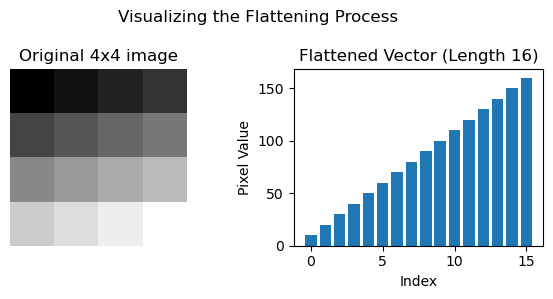

In [13]:
import matplotlib.pyplot as plt
import numpy as np

image = np.array(
    [
        [10, 20, 30, 40],
        [50, 60, 70, 80],
        [90, 100, 110, 120],
        [130, 140, 150, 160]
    ]
)

flattened = image.flatten()

print(flattened.shape)
print(flattened)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original 4x4 image')
ax[0].axis('off')

ax[1].bar(np.arange(len(flattened)), flattened)
ax[1].set_title("Flattened Vector (Length 16)")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Pixel Value")

plt.suptitle("Visualizing the Flattening Process")
plt.tight_layout()
plt.show()

**Lets keep in mind that**, flattening **destroys spatial structure** (e.g., neighborhood relationships between pixels). CNNs handle this better — we’ll explore that in later projects. For now, we’re using MLPs, so flattening is necessary.

Now let's flatten one image:

In [14]:
# get any random image, index between 0 and 50000
image, label = train_dataset[12344]
print(f'Original Shape: {image.shape}')

flattened = image.view(-1) # or image.reshaped(-1)
print(F"Flattened Shape: {flattened.shape}")

Original Shape: torch.Size([3, 32, 32])
Flattened Shape: torch.Size([3072])


The `.view(-1)` method in PyTorch reshapes the image tensor to a **1D vector**. This is what we’ll feed into a fully connected layer of an MLP.

Just to share, we can also **reshape** the 1D vector back into an image format: `reshaped = flattened.view(3, 32, 32)`. Useful for debugging or visual checks!

> **❗️ But Wait — We Must Flatten the Entire Dataset**

Flattening just one image for demo purposes is not enough. We need to make sure that all training, validation, and test images are automatically flattened before being passed to the model.

**✅ Solution: Update the Transform Pipeline**

Let’s redefine our transform to convert image to tensor as well as to flatten it to a 1D vector.

In [15]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)

**🔁 Reload Datasets with Flattening Transform**

In [16]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset  = CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


>Next Up:

Now that we’ve flattened images, let’s normalize pixel values — another vital preprocessing step that makes training faster and more stable.

---

**✅ Code Task 4.1.3.1 – Verify Flattening of Image**

📘 Goal: Flatten one CIFAR-10 image tensor (3×32×32 → 3072) and confirm new shape. This checks understanding of flattening step for MLP input.

In [17]:
# Task 3 – Verify flattening

# Step 1: Get one image sample
CT_image_flat, CT_label_flat = train_dataset[2]

CT_image_flat = CT_image_flat.view(3, 32, 32)
# Step 2: Flatten the image
CT_flattened = CT_image_flat.view(-1)

# Step 3: Print original and flattened shapes
print("CT_Original shape:", CT_image_flat.shape)
print("CT_Flattened shape:", CT_flattened.shape)   # Expect torch.Size([3072])


CT_Original shape: torch.Size([3, 32, 32])
CT_Flattened shape: torch.Size([3072])


### **4. Prepare DataLoaders — Train, Validation, and Test**

Now that our **CIFAR-10** dataset is loaded and normalized, we’ll use **PyTorch DataLoaders** to prepare it for training.

>`torch.utils.data.DataLoader` helps with efficient and flexible data loading by:

- **Batching**: Feeds small groups of images (e.g., 64) at each training step
- **Shuffling**: Randomizes the order of samples each epoch to improve generalization
- **Parallel Loading**: Uses multiple workers to load data faster in the background

CIFAR-10 provides us with: **50,000 training images** and **10,000 test images**

We'll further split the **training set** into **45,000 for training** and **5,000 for validation**

>✅ Why This Split?

- **Training set (45K)**: Used to train the model (weights updated here)
- **Validation set (5K)**: Used during training to monitor performance and detect overfitting
- **Test set (10K)**: Held out until the end for final unbiased evaluation

> Using separate validation and test sets allows us to monitor model behavior during training without contaminating our final performance estimate.

In [18]:
import torch
from torch.utils.data import DataLoader, random_split

# set manual seed for reproducibility
torch.manual_seed(42)

# set batch size
batch_size = 64

# get train and validation size
train_size = int(len(train_dataset) * 0.9)
val_size   = len(train_dataset) - train_size

train_data, val_data = random_split(train_dataset,  [train_size, val_size])

# Using DataLoader, load the data in
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader  =  DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check sizes
print('Train batches:', len(train_loader))
print('Validation batches', val_loader.__len__())
print('Test batches', len(test_loader))

Train batches: 704
Validation batches 79
Test batches 157


In [19]:
# check the shape of of an image and label in the first batch
for images, labels in train_loader:
    print(f"✅ Batch shape: {images.shape}")  # Should be [batch_size, 3072]
    print(f"✅ Labels shape: {labels.shape}")  # Should be [batch_size]
    break  # Just check the first batch

✅ Batch shape: torch.Size([64, 3072])
✅ Labels shape: torch.Size([64])


➡️ Next, we’ll build a **Simple MLP architecture** to classify these images using the CIFAR-10 labels.

---

**✅ Code Task 4.1.4.1 – Check DataLoader Batch Shapes**

📘 Goal: Fetch one batch from train_loader and print shape of features and labels to verify batching logic (64 × 3072 for features, 64 for labels).

In [20]:
# Task – Check DataLoader batch shape

# Step 1: Fetch one batch
CT_images_batch, CT_labels_batch = next(iter(train_loader))

# Step 2: Print shapes
print("CT_Batch feature shape:", CT_images_batch.shape)   # Expect [64, 3072]
print("CT_Batch label shape:", CT_labels_batch.shape)     # Expect [64])

CT_Batch feature shape: torch.Size([64, 3072])
CT_Batch label shape: torch.Size([64])


---

### **5. Define a Simple MLP for CIFAR-10**

We’ll now define our **first neural network** — a basic MLP (Multilayer Perceptron).

>MLP Structure

We flattened each 32×32 RGB image into a **3072-dimensional vector**.

Here’s our architecture:

- **Input layer**: 3072 units (32×32×3)
- **Hidden layer**: 128 units + ReLU
- **Output layer**: 10 units (logits, one per class)

This is a **fully connected network** — each neuron connects to every unit in the next layer.

We start with MLP to understand baseline performance — **before introducing CNNs** (which are better suited for images). You’ll soon see why.

In [21]:
# check the shape of of an image and label in the first batch
image, label = next(iter(train_loader))
print(F"Image Shape: {image.shape}")
print(F"'Label Shape: {label.shape}")

Image Shape: torch.Size([64, 3072])
'Label Shape: torch.Size([64])


In [22]:
import torch.nn as nn
class SimpleMLP(nn.Module):
    def __init__(self, input_dim = 32*32*3, hidden_dim = 128, output_dim=10):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
    
    def forward(self, x):
        return self.network(x)

# Instantiate model
mlp_model = SimpleMLP()

print(mlp_model)

SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [23]:
sum(p.numel() for p in mlp_model.parameters())

394634

>What Does This Model Do?

- First `Linear` layer transforms 3072 → 128
- `ReLU` adds non-linearity to learn complex patterns
- Final `Linear` outputs 10 logits, which are used by CrossEntropyLoss

>Important Notes

- We don’t use `Softmax` in the model — because `nn.CrossEntropyLoss` internally applies it.
- We'll **track both training loss and accuracy** as we proceed.

➡️ In the next section, we’ll train this model using **CrossEntropyLoss** and check how well it learns on CIFAR-10.

---

### **6. Training the MLP on CIFAR-10**

We now train our `SimpleMLP` using:

- **Loss**: `CrossEntropyLoss`, ideal for multiclass classification.
- **Optimizer**: `Adam`, a widely used optimizer combining momentum and adaptive learning rates.
- **Epochs**: We'll train for a few epochs and observe the trends in loss and accuracy.

**Key Concepts**

**Loss Function**: We use `nn.CrossEntropyLoss` which combines **log-softmax** and **negative log-likelihood**. It expects raw logits as model output and integer class labels as targets

**Optimizer**: We use `Adam` for efficiency and stability. We'll update weights based on gradients computed by backpropagation.

**Metrics**: We’ll track **Training loss** (average per epoch) and **Training accuracy** (proportion of correct predictions).

In [24]:
from tqdm import tqdm

In [25]:
tqdm(range(3000))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [2]:
import torch.nn as nn

In [26]:
import time
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model.to(device)

training_loss = []
epochs = 10
training_acc = []

start_time = time.perf_counter()
for epoch in tqdm(range(epochs), desc='Training Progress'):
    running_loss = 0.0
    correct = 0
    total = 0
    # set the model to train
    mlp_model.train()

    for images, labels in train_loader:
        # images and labels to device
        images, labels = images.to(device), labels.to(device)
        # images = images.view(images.size(0), -1)  # ← would be needed if not pre-flattened
        #forward propagation
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #========= Accumulate stats ==========
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc)
    print(F"Epoch [{epoch + 1} / {epochs}] - Loss: {epoch_loss:.4f} | Accuracy {epoch_acc:.4f}")

end_time = time.perf_counter()
print(f"The model trained in {end_time - start_time} seconds")


Epoch [1 / 10] - Loss: 1.8640 | Accuracy 0.3309


Epoch [2 / 10] - Loss: 1.7050 | Accuracy 0.3936


Epoch [3 / 10] - Loss: 1.6423 | Accuracy 0.4162


Epoch [4 / 10] - Loss: 1.6010 | Accuracy 0.4321


Epoch [5 / 10] - Loss: 1.5720 | Accuracy 0.4462


Epoch [6 / 10] - Loss: 1.5467 | Accuracy 0.4532


Epoch [7 / 10] - Loss: 1.5271 | Accuracy 0.4613


Epoch [8 / 10] - Loss: 1.5115 | Accuracy 0.4641


Epoch [9 / 10] - Loss: 1.4980 | Accuracy 0.4698


Training Progress: 100%|██████████| 10/10 [03:00<00:00, 18.01s/it]

Epoch [10 / 10] - Loss: 1.4809 | Accuracy 0.4757
The model trained in 179.14658598700044 seconds


After 10 epochs, here’s what we observed:

- **Initial loss**: 1.86 → **Final loss**: 1.48
- **Accuracy improved** from **33% to ~47%** over the epochs

The model is **learning steadily** — loss is decreasing and accuracy is improving. But performance is still **far from ideal**. With **only one hidden layer** and **no spatial awareness**, it’s expected that:

  - The MLP **struggles to capture image structure** (e.g., edges, shapes, textures)
  - It **treats pixels as independent features**, which is suboptimal for images
  - The model is **underfitting**, though improving

>🔧 What Can Help?

- **Deeper MLPs** (more hidden layers)
- **Better optimizers or learning rate tuning**
- **Convolutional Neural Networks (CNNs)** — designed to leverage **spatial locality**

➡️ In the next section, we’ll **evaluate this model on the test set** using accuracy and a **confusion matrix**, to understand **which classes it gets right or wrong**.

---

**✅ Code Task 4.1.6.1 – One Training Epoch on CIFAR-10**

📘 Goal: Perform one training epoch on CIFAR-10 using the provided mlp_model, compute and print final epoch loss and accuracy. Reinforces training loop fundamentals.

In [27]:
# Task 5 – One training epoch

mlp_model.train()

CT_running_loss = 0.0
CT_correct = 0
CT_total = 0

for CT_images, CT_labels in train_loader:
    CT_images, CT_labels = CT_images.to(device), CT_labels.to(device)

    # Forward pass
    CT_outputs = mlp_model(CT_images)
    CT_loss = criterion(CT_outputs, CT_labels)

    # Backpropagation
    optimizer.zero_grad()
    CT_loss.backward()
    optimizer.step()

    # Accumulate stats
    CT_running_loss += CT_loss.item() * CT_labels.size(0)
    _, CT_predicted = torch.max(CT_outputs, 1)
    CT_correct += (CT_predicted == CT_labels).sum().item()
    CT_total += CT_labels.size(0)

# Compute average loss and accuracy
CT_epoch_loss = CT_running_loss / CT_total
CT_epoch_acc = CT_correct / CT_total

print(f"CT_OneEpoch Loss: {CT_epoch_loss:.4f}")
print(f"CT_OneEpoch Accuracy: {CT_epoch_acc:.4f}")


CT_OneEpoch Loss: 1.4719
CT_OneEpoch Accuracy: 0.4772


### **7. Evaluation**

We will, now:

- Run the trained model on the test set.
- Compute test accuracy.
- Plot the confusion matrix.
- Interpret where the model succeeds or struggles.

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# set model in evaluation mode

mlp_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = mlp_model(images)
        _, predictions = torch.max(outputs, 1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.4524


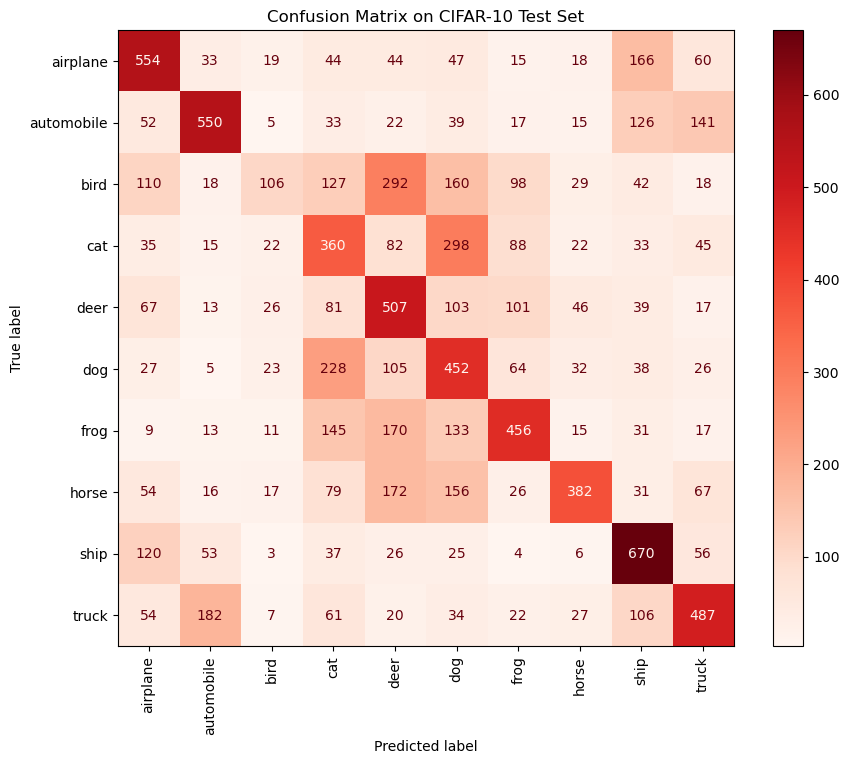

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Reds', xticks_rotation=90)
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.show()

Each row of the matrix represents the **true class**, and each column the **predicted class**.  
The diagonal elements represent **correct predictions** — so higher values along the diagonal are desirable.

>🔍 What Can We Observe?

- The model correctly identifies certain classes well (e.g., **automobile**, **ship**, and **truck**), as seen by high diagonal values.
- **Bird**, **cat**, and **frog** have significantly more **off-diagonal confusion**, especially with each other — which is intuitive because they share visual similarities.
- **Ship** is often misclassified as **airplane**, likely due to shared backgrounds like sky or water in low-res images.
- **Truck** frequently gets confused with **automobile**, which makes sense given both are vehicles.

>⚠️ Key Takeaways

- **Accuracy is not the whole story**: We see that some classes (like `dog`, `cat`, `bird`) suffer more than others.
- **Model struggles with subtle visual distinctions** between classes — a key limitation of **MLPs** when applied to images.
- **Spatial information is lost** when we flatten the image into a 1D vector.

➡️ In the next section, we’ll discuss **why MLPs struggle with image data**, and how **convolutional architectures** (covered soon!) are designed to address these exact issues.

---

### **8. Why MLPs Struggle with Image Data**

Even after training a fully connected neural network (MLP) on CIFAR-10:
- Accuracy plateaued around **45–46%**.
- Confusion matrix showed **lots of misclassifications**, especially for visually similar categories.
- Some classes (e.g., `ship`, `truck`) did relatively well, while others (like `bird`, `cat`) performed poorly.

>**But Why?**

**1. 🧱 Loss of Spatial Structure**

MLPs require us to **flatten images** into long 1D vectors.

- A 32×32 color image becomes a **3072-length vector** (32 × 32 × 3).
- All **spatial relationships** between neighboring pixels are **destroyed**.
- This makes it harder for the model to learn **local patterns** (e.g., edges, corners, textures).

The model sees no 2D structure — just a long list of numbers.

**2. 📏 Too Many Parameters**

Because every pixel is connected to **every neuron**, the number of parameters explodes:

- For a simple MLP with 3072 inputs and a hidden layer of 256 neurons:
  → **3072 × 128 = 3,93,216 weights** in the first layer alone!

This leads to **High memory usage**, **Overfitting risk** (especially with limited data), and **Slower convergence** during training.

**3. 🚫 No Inductive Bias**

MLPs have **no built-in assumptions** about images. They treat all input features (pixels) as equally important, regardless of **position** or **locality**.

Contrast this with:
- **Convolutional Neural Networks (CNNs)**, which:
  - Exploit local patterns (like edges, textures)
  - Share weights (via kernels)
  - Have fewer parameters
  - Learn hierarchical representations

**What We'll Do Next**

To address these challenges, in upcoming notebooks we'l try **deeper MLPs** to understand how depth helps (a little). Then we will **introduce CNNs**, which are designed **specifically for image data** and will learn how CNNs preserve spatial structure while reducing parameter count.

➡️ In the next notebook, we’ll try to improve things by going **deeper** — adding more layers to our MLP and using better training tricks.

---